In [1]:
%load_ext autoreload
%autoreload 2
from factor_processing_utils import *

In [ ]:
# 研究时间
start_date = "2015-01-01"
end_date = "2025-07-01"

# 基准指数
index_item = "000852.XSHG"
change_days = 20
month_day = 20
year_day = 252

# 券池
stock_universe = INDEX_FIX(start_date, end_date, index_item)
stock_list = stock_universe.columns.tolist()
date_list = stock_universe.index.tolist()

##### Asness(2017) 对 Gordon成长模型的分解来定义质量因子
##### 光大证券2018.11.03《以质取胜：EBQC综合质量因子详解》
##### 质量因子：盈利能力、成长能力、营运效率、盈余质量、安全性、公司治理

In [ ]:
## 全部资产现金回收率 = 经营性现金流/总资产
cfoa_mrq = Factor("cash_flow_from_operating_activities_mrq_0") / Factor(
    "total_assets_mrq_0"
)
## 资产周转率变动 = 当期营业收入/当期总资产 - 去年同期营业收入/去年同期总资产
atdy_mrq = Factor("operating_revenue_mrq_0") / Factor("total_assets_mrq_0") - Factor(
    "operating_revenue_mrq_4"
) / Factor("total_assets_mrq_4")
## 现金流动负债率比 = 经营性现金流/流动负债
ccr_mrq = Factor("cash_flow_from_operating_activities_mrq_0") / Factor(
    "current_liabilities_mrq_0"
)
## 营业利润同比增长率 = （当期营业利润 - 去年同期营业利润）/绝对值（去年同期营业利润）
op_q_yoy_mrq = (
    Factor("profit_from_operation_mrq_0") - Factor("profit_from_operation_mrq_4")
) / ABS(Factor("profit_from_operation_mrq_4"))
## 股息率
dividend_yield_ttm = Factor("dividend_yield_ttm")
## 市盈率
pe_ttm = Factor("market_cap_3") / Factor("net_profit_parent_company_lyr_0")
## 盈市率 = 1/市盈率
ep_ttm = Factor("net_profit_parent_company_lyr_0") / Factor("market_cap_3")
## 营业利润率 = 营业利润/营业收入
opr_mrq = Factor("profit_from_operation_mrq_0") / Factor("operating_revenue_mrq_0")

# 量价因子
HIGH = Factor("high")
LOW = Factor("low")
OPEN = Factor("open")
CLOSE = Factor("close")
VOLUME = Factor("volume")
TURNOVER = Factor("total_turnover")


def turnover_rate(order_book_ids, start_date, end_date):
    return (
        get_turnover_rate(order_book_ids, start_date, end_date, fields="today")
        .today.unstack("order_book_id")
        .reindex(
            columns=order_book_ids,
            index=pd.to_datetime(get_trading_dates(start_date, end_date)),
        )
    )


DAILY_TURNOVER_RATE = UserDefinedLeafFactor("DAILY_TURNOVER_RATE", turnover_rate)

# 流动性因子
## 过去20日换手率的均值
liq_turn_avg = MA(DAILY_TURNOVER_RATE, 20)
## 过去20日换手率的标准差
liq_turn_std = STD(DAILY_TURNOVER_RATE, 20)
## 过去20日成交额的均值/成交额的标准差
liq_zamount = MA(TURNOVER, 20) / STD(TURNOVER, 20)

# 量价相关性
## 过去20天收盘价和日换手率之间的相关性
corr_price_turn = CORR(CLOSE, DAILY_TURNOVER_RATE, 20)

# 波动率
## 过去20天的高低价差比之间的波动率
vol_highlow_std = STD(HIGH / LOW, 20)
## 过去20天上影线的波动率
vol_up_shadow_std = STD((HIGH - MAX(OPEN, CLOSE)) / HIGH, 20)

# 动量
month_day, year_day = 20, 252
# 过去1个月动量
mmt_normal_M = CLOSE / REF(CLOSE, month_day) - 1
# 过去1年动量 （剔除过去1个月动量）
mmt_normal_A = REF(CLOSE, month_day) / REF(CLOSE, year_day) - 1


factor_dict = {
    "atdy_mrq": atdy_mrq,
    "ccr_mrq": ccr_mrq,
    "cfoa_mrq": cfoa_mrq,
    "dividend_yield_ttm": dividend_yield_ttm,
    "ep_ttm": ep_ttm,
    "op_q_yoy_mrq": op_q_yoy_mrq,
    "opr_mrq": opr_mrq,
    "pe_ttm": pe_ttm * -1,
    "corr_price_turn": corr_price_turn * -1,
    "liq_zamount": liq_zamount,
    "mmt_normal_M": mmt_normal_M * -1,
    "vol_high_low_std": vol_highlow_std * -1,
}

In [ ]:
import time

for k, v in tqdm(factor_dict.items()):

    # 获取raw因子值
    df = execute_factor(v, stock_list, start_date, end_date)
    raw_path = f"factor_lib/raw/{k}_{index_item}_{start_date}_{end_date}.pkl"
    df.to_pickle(raw_path)

    time.sleep(3)
    neu_path = f"factor_lib/neu/{k}_{index_item}_{start_date}_{end_date}.pkl"
    # 清洗之后存入neu文件夹
    df = data_clean(df, stock_universe, index_item)
    df.to_pickle(neu_path)

In [17]:
# 从neu文件夹读取因子值，存入value_dict
value_dict = {}
for k, v in tqdm(factor_dict.items()):
    value_dict[k] = pd.read_pickle(
        f"factor_lib/neu/{k}_{index_item}_{start_date}_{end_date}.pkl"
    )

100%|██████████| 12/12 [00:00<00:00, 54.76it/s]


In [32]:
ic_df = pd.DataFrame(index=date_list)
ic_summary = pd.DataFrame()
for k, v in value_dict.items():
    ic, ic_summary_temp = calc_ic(v, 20, index_item, k)
    ic_df = pd.concat([ic_df, ic], axis=1)
    ic_summary = pd.concat([ic_summary, ic_summary_temp.set_index("name")], axis=0)

{'name': 'atdy_mrq', 'change_day': 20, 'IC mean': 0.021, 'IC std': 0.0505, 'IR': 0.4167, 'IC>0': 0.6669, 'ABS_IC>2%': 0.7464, 't_stat': 20.9536}
{'name': 'ccr_mrq', 'change_day': 20, 'IC mean': 0.0185, 'IC std': 0.0479, 'IR': 0.3862, 'IC>0': 0.6452, 'ABS_IC>2%': 0.6709, 't_stat': 19.4173}
{'name': 'cfoa_mrq', 'change_day': 20, 'IC mean': 0.019, 'IC std': 0.052, 'IR': 0.3645, 'IC>0': 0.64, 'ABS_IC>2%': 0.7009, 't_stat': 18.3248}
{'name': 'dividend_yield_ttm', 'change_day': 20, 'IC mean': 0.0328, 'IC std': 0.0738, 'IR': 0.4451, 'IC>0': 0.6962, 'ABS_IC>2%': 0.8271, 't_stat': 22.3809}
{'name': 'ep_ttm', 'change_day': 20, 'IC mean': 0.036, 'IC std': 0.0877, 'IR': 0.4102, 'IC>0': 0.6764, 'ABS_IC>2%': 0.8445, 't_stat': 20.6234}
{'name': 'op_q_yoy_mrq', 'change_day': 20, 'IC mean': 0.0326, 'IC std': 0.0702, 'IR': 0.4649, 'IC>0': 0.6891, 'ABS_IC>2%': 0.7963, 't_stat': 23.3751}
{'name': 'opr_mrq', 'change_day': 20, 'IC mean': 0.0315, 'IC std': 0.0726, 'IR': 0.4342, 'IC>0': 0.6543, 'ABS_IC>2%': 0

In [18]:
factor_names = [
    "atdy_mrq",
    "ccr_mrq",
    "liq_zamount",
    "corr_price_turn",
    "mmt_normal_M",
    "vol_high_low_std",
]

{'name': 'ew_combo', 'change_day': 20, 'IC mean': 0.019, 'IC std': 0.052, 'IR': 0.3645, 'IC>0': 0.64, 'ABS_IC>2%': 0.7009, 't_stat': 18.3248}


100%|██████████| 128/128 [00:00<00:00, 272.27it/s]


             0
策略累计收益  0.9919
策略年化收益  0.0705
基准累计收益  0.0630
基准年化收益  0.0061
阿尔法     0.0678
贝塔      1.0422
波动率     0.3243
夏普比率    0.1249
下行波动率   0.2766
索提诺比率   0.1464
跟踪误差    0.0567
信息比率    1.1368
最大回撤    0.6641
卡玛比率    0.1062
超额累计收益  0.8738
超额年化收益  0.0641
超额波动率   0.0580
超额夏普    0.5871
超额最大回测  0.1311
胜率      0.5518
盈亏比     1.0166


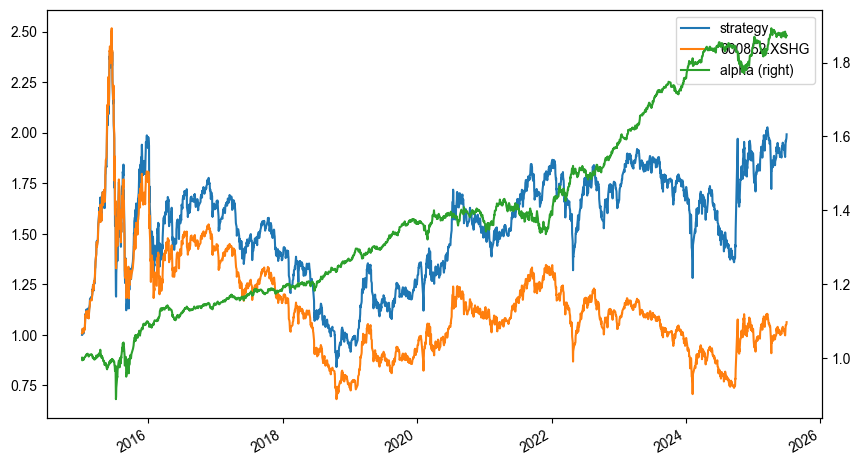

In [44]:
factor_names = ["cfoa_mrq"]
ew_combo = pd.DataFrame()
for factor_name in factor_names:
    ew_combo = ew_combo.add(standardize(value_dict[factor_name]), fill_value=0)
ic, ic_report = calc_ic(ew_combo, 20, index_item, "ew_combo")
df = ew_combo
buy_list = get_buy_list(df, rank_n=200)
df_weight = buy_list.div(buy_list.sum(axis=1), axis=0)
df_weight = df_weight.shift(1).dropna(how="all")
account_result = backtest(df_weight)
performance_cumnet, result = get_performance_analysis(
    account_result, benchmark_index=index_item
)

In [38]:
performance_annual_performance = (
    performance_cumnet.pct_change().resample("Y").apply(lambda x: (1 + x).prod() - 1).T
)
display(performance_annual_performance)

,2015-12-31,2016-12-31,2017-12-31,2018-12-31,2019-12-31,2020-12-31,2021-12-31,2022-12-31,2023-12-31,2024-12-31,2025-12-31
strategy,1.112733,-0.152776,-0.150148,-0.305837,0.330471,0.234623,0.304752,-0.096742,-0.058754,0.144887,0.095471
000852.XSHG,0.794027,-0.214905,-0.180289,-0.363371,0.247320,0.183264,0.215713,-0.209319,-0.077333,0.060966,0.033657
alpha,0.168928,0.079136,0.036769,0.090372,0.066664,0.043404,0.073240,0.142380,0.020137,0.079098,0.059801
